In [6]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from bs4 import BeautifulSoup

In [7]:
import wandb

In [8]:
from PIL import Image
import cv2
import numpy as np
import time
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
import albumentations
import albumentations.pytorch
from matplotlib import pyplot as plt
import os
import random

In [3]:
import albumentations as A

In [4]:
torch.manual_seed(0)

In [1]:
import gc

gc.collect()

torch.cuda.empty_cache()

NameError: name 'torch' is not defined

agumentation guide: https://github.com/albumentations-team/albumentations#spatial-level-transforms

Follow this: https://pseudo-lab.github.io/Tutorial-Book-en/chapters/en/object-detection/Ch3-preprocessing.html

In [29]:
# CUDA
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [9]:
# helper function for dataset
def generate_box(obj):
    
    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

In [10]:
def generate_label(obj):
    # only have ships
    return 0 

In [11]:
def generate_target(file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "xml")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))


        boxes = torch.as_tensor(boxes, dtype=torch.float32) 
        labels = torch.as_tensor(labels, dtype=torch.int64) 
        
        target = {}

        
        target["boxes"] = boxes
        target["labels"] = labels
        
        return target


In [12]:
def plot_image_from_output(img, annotation):
    
    img = img.permute(1,2,0)
    
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    
    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 0 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        elif annotation['labels'][idx] == 1 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
            
        else :
        
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')
        
        ax.add_patch(rect)

    plt.show()

In [13]:
list(sorted(os.listdir("annotations_yolo/")))[0][:-3]

'01_10_12.'

In [14]:
class ShipDataset:
    def __init__(self, path, transform=None):
        self.path = path
        self.files = list(sorted(os.listdir("annotations_yolo/")))
        self.transform = transform
        
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_image = self.files[idx][:-3] + 'jpg'
        file_label = self.files[idx][:-3] + 'xml'

        img_path = os.path.join("images/", file_image)
        label_path = os.path.join("annotations/", file_label)
        
        #print(img_path)
        # Read an image with OpenCV, gray scale
        image = cv2.imread(img_path,0)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = image/255.0
        target = generate_target(label_path)

        #start_t = time.time()
        if self.transform:
            transformed = self.transform(image = image, bboxes = target['boxes'], labels = target['labels'])
            image = torch.Tensor(transformed['image'])
            target = {'boxes':torch.Tensor(transformed['bboxes']).reshape(-1,4), 'labels':torch.Tensor(transformed['labels'])}
        else:
            image = torch.tensor(image,dtype=torch.float32)
        
        image = torch.unsqueeze(image, dim=0)
            
        return image, target #, total_time

In [15]:
# TODO: Include transformations/albumnations for dataset
# resize to 640, include mirror images, as well as gaussian noise 

In [16]:
# Albumenation augmentation ideas
# RandomBrightnessContrast
# GaussNoise

In [17]:
# Declare an augmentation pipeline
transform = A.Compose([
    #A.HorizontalFlip(p=1),
    A.GaussianBlur(p=1),
    #A.GaussNoise(p=1,var_limit=(0,1)),
    A.pytorch.ToTensor()
], bbox_params=A.BboxParams(format='pascal_voc',label_fields=[]))

NameError: name 'A' is not defined

In [18]:
transform = A.Compose([
    A.Resize(800,800),
    albumentations.OneOf([
                          albumentations.HorizontalFlip(p=0.5),
                          albumentations.RandomRotate90(p=0.5),
                          albumentations.VerticalFlip(p=0.5)            
    ], p=1),
    albumentations.OneOf([
                          albumentations.MotionBlur(p=0.5),
                          #albumentations.GaussNoise(p=0.5,var_limit=(0,1))                 
    ], p=1),
    #albumentations.pytorch.ToTensor()
], bbox_params=A.BboxParams(format='pascal_voc',label_fields=[]))

NameError: name 'A' is not defined

In [19]:
# for some reason albumentations.pytorch.ToTensor() does not work for bbox

In [20]:
dataset = ShipDataset(
    path = 'images/',
    #transform=transform
)
len(dataset)

1859

In [21]:
img, annotation = dataset[0]

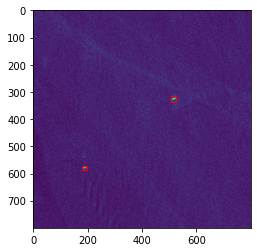

In [22]:
plot_image_from_output(img, annotation)

In [23]:
train_set, val_set = torch.utils.data.random_split(dataset, [1400,459],)
len(train_set), len(val_set)

(1400, 459)

In [24]:
train_set[0][1]["boxes"]

tensor([[  1., 281.,   6., 299.],
        [ 20., 461.,  35., 493.],
        [ 37., 246.,  55., 268.],
        [242.,  15., 251.,  26.],
        [190.,  49., 202.,  66.],
        [188., 133., 199., 150.],
        [213.,  65., 223.,  83.],
        [221.,  82., 233.,  98.],
        [311.,  13., 321.,  26.],
        [247.,  77., 256.,  92.],
        [274.,  60., 285.,  77.],
        [294.,  52., 307.,  70.],
        [236., 123., 247., 138.],
        [290., 145., 301., 160.],
        [280., 164., 294., 175.],
        [264., 196., 275., 211.],
        [246., 236., 259., 248.],
        [395.,   6., 404.,  22.],
        [385.,  26., 400.,  57.],
        [366., 106., 387., 118.],
        [356., 117., 367., 133.],
        [337., 149., 352., 167.],
        [105., 494., 113., 503.],
        [381., 186., 387., 191.],
        [341., 213., 347., 220.]])

In [25]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [26]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=8, collate_fn=collate_fn)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=8,collate_fn=collate_fn)

In [27]:
train_loader

In [25]:
retina = torchvision.models.detection.retinanet_resnet50_fpn(num_classes = 1, pretrained=False, pretrained_backbone = True)


/home/alex/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/alex/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/alex/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and will be removed in 0.15, please use 'weights_backbone' instead.
  warnings.warn(
/home/alex/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights_backbone' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent

In [26]:
num_epochs = 100
retina.to(device)
    
# parameters
params = [p for p in retina.parameters() if p.requires_grad] # select parameters that require gradient calculation
optimizer = torch.optim.SGD(params, lr=0.001,
                                momentum=0.9, weight_decay=0.001)

len_dataloader = len(train_loader)
all_loss = []
# about 4 min per epoch on Colab GPU
for epoch in range(num_epochs):
    start = time.time()
    retina.train()

    i = 0    
    epoch_loss = 0
    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        
        #print(targets)
        

        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        #print(images)
        loss_dict = retina(images, targets) 

        losses = sum(loss for loss in loss_dict.values()) 

        i += 1

        optimizer.zero_grad()
        losses.backward()

        torch.nn.utils.clip_grad_norm_(params,max_norm=2.0)
        optimizer.step()
        
        epoch_loss += losses 
    all_loss.append(epoch_loss)
    if epoch % 5 == 0:
        print("Epoch #: {0}, Loss: {1}, Time: {2}".format(epoch, epoch_loss.item(),time.time() - start))
        

Epoch #: 0, Loss: 343.5390930175781, Time: 2304.265037536621
Epoch #: 5, Loss: 346.0791320800781, Time: 2273.597951412201
Epoch #: 10, Loss: 361.30963134765625, Time: 2275.1648490428925


KeyboardInterrupt: 

# Save Model If needed

In [ ]:
torch.save(retina.state_dict(), "models/retTest1.pt")

In [ ]:
# getting a Nan value for loss, possible causes:
#   Gradients exploding, use gradient clipping
#   Data is not normalized, reduce values of data

## Inference

In [30]:
retina = torchvision.models.detection.retinanet_resnet50_fpn(num_classes=2)
retina.load_state_dict(torch.load("models/retTest3.pt"))
retina.eval()
retina.to(device)

RetinaNet(
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): FrozenBatchNorm2d(256, e

In [5]:
state_dict = wandb.restore('retTest3.pt', run_path="ship-detection/sar-ship-detection/qex3r8el")

KeyboardInterrupt: 

AttributeError: 'NoneType' object has no attribute 'dir'

In [31]:
def plot_image_from_output2(img, annotation):
    
    img = img.cpu().permute(1,2,0)
    
    rects = []

    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 0 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        elif annotation['labels'][idx] == 1 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
            
        else :
        
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        rects.append(rect)

    return img, rects

In [32]:
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold : #select idx which meets the threshold
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]


    return preds

In [33]:
from tqdm import tqdm

labels = []
preds_adj_all = []
annot_all = []

for im, annot in tqdm(val_loader, position = 0, leave = True):
    im = list(img.to(device) for img in im)
    #annot = [{k: v.to(device) for k, v in t.items()} for t in annot]

    for t in annot:
        labels += t['labels']

    with torch.no_grad():
        preds_adj = make_prediction(retina, im, 0.3)
        preds_adj = [{k: v.to(torch.device('cpu')) for k, v in t.items()} for t in preds_adj]
        preds_adj_all.append(preds_adj)
        annot_all.append(annot)

100%|██████████| 58/58 [00:28<00:00,  2.00it/s]


Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Index Error
Inde

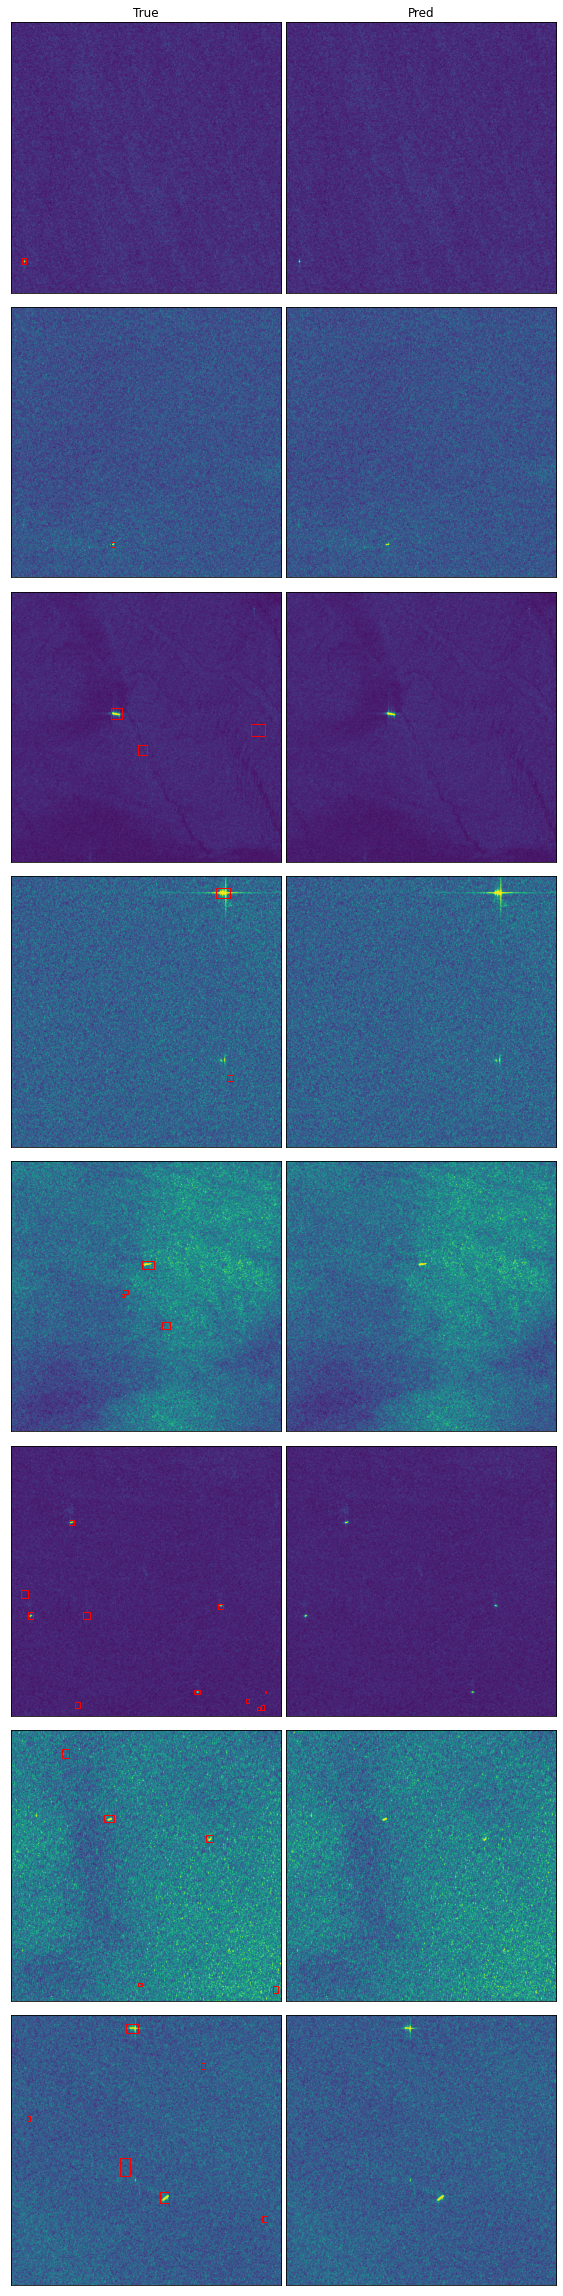

In [34]:
nrows = 8
ncols = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*4, nrows*4))

batch_i = 0
for im, annot in val_loader:
    pos = batch_i * 4 + 1
    for sample_i in range(len(im)) :
        
        img, rects = plot_image_from_output2(im[sample_i], annot[sample_i])
        try:
            axes[(pos)//2, 1-((pos)%2)].imshow(img)
        except:
            print("Index Error")
        for rect in rects:
            try:
                axes[(pos)//2, 1-((pos)%2)].add_patch(rect)
            except:
                print("Index Error")
        img, rects = plot_image_from_output2(im[sample_i], preds_adj_all[batch_i][sample_i])
        try:
            axes[(pos)//2, 1-((pos+1)%2)].imshow(img)
        except:
            print("Index Error")
        for rect in rects:
            try:
                axes[(pos)//2, 1-((pos+1)%2)].add_patch(rect)
            except:
                print("Index Error")
        pos += 2

    batch_i += 1
    if batch_i == 4:
        break

# remove xtick, ytick
for idx, ax in enumerate(axes.flat):
    ax.set_xticks([])
    ax.set_yticks([])

colnames = ['True', 'Pred']

for idx, ax in enumerate(axes[0]):
    ax.set_title(colnames[idx])

plt.tight_layout()
plt.show()


In [35]:
def get_batch_statistics(outputs, targets, iou_threshold):
    """ Compute true positives, predicted scores and predicted labels per sample """
    batch_metrics = []
    for sample_i in range(len(outputs)):

        if outputs[sample_i] is None:
            continue

        output = outputs[sample_i] # predict
        # pred_boxes = output['boxes']
        # pred_scores = output['scores']
        # pred_labels = output['labels']

        true_positives = torch.zeros(output['boxes'].shape[0])   # 예측 객체 개수
 
        annotations = targets[sample_i]  # actual
        target_labels = annotations['labels'] if len(annotations) else []
        if len(annotations):    # len(annotations) = 3
            detected_boxes = []
            target_boxes = annotations['boxes']

            for pred_i, (pred_box, pred_label) in enumerate(zip(output['boxes'], output['labels'])): # 예측값에 대해서..

                # If targets are found break
                if len(detected_boxes) == len(target_labels): # annotations -> target_labels
                    break

                # Ignore if label is not one of the target labels
                if pred_label not in target_labels:
                    continue

                iou, box_index = bbox_iou(pred_box.unsqueeze(0), target_boxes).max(0)   # box_index : 실제 어떤 바운딩 박스랑 IoU 가 가장 높은지 index
                if iou >= iou_threshold and box_index not in detected_boxes: # iou만 맞으면 통과?
                    true_positives[pred_i] = 1
                    detected_boxes += [box_index]  # 예측된거랑 실제랑 매핑해서 하나씩 index 채움
        batch_metrics.append([true_positives, output['scores'], output['labels']])
    return batch_metrics

def bbox_iou(box1, box2, x1y1x2y2=True):
    """
    Returns the IoU of two bounding boxes
    """
    if not x1y1x2y2:
        # Transform from center and width to exact coordinates
        b1_x1, b1_x2 = box1[:, 0] - box1[:, 2] / 2, box1[:, 0] + box1[:, 2] / 2
        b1_y1, b1_y2 = box1[:, 1] - box1[:, 3] / 2, box1[:, 1] + box1[:, 3] / 2
        b2_x1, b2_x2 = box2[:, 0] - box2[:, 2] / 2, box2[:, 0] + box2[:, 2] / 2
        b2_y1, b2_y2 = box2[:, 1] - box2[:, 3] / 2, box2[:, 1] + box2[:, 3] / 2
    else:
        # Get the coordinates of bounding boxes
        b1_x1, b1_y1, b1_x2, b1_y2 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
        b2_x1, b2_y1, b2_x2, b2_y2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]

    # get the corrdinates of the intersection rectangle
    inter_rect_x1 = torch.max(b1_x1, b2_x1)
    inter_rect_y1 = torch.max(b1_y1, b2_y1)
    inter_rect_x2 = torch.min(b1_x2, b2_x2)
    inter_rect_y2 = torch.min(b1_y2, b2_y2)
    # Intersection area
    inter_area = torch.clamp(inter_rect_x2 - inter_rect_x1 + 1, min=0) * torch.clamp(inter_rect_y2 - inter_rect_y1 + 1, min=0)
    # Union Area
    b1_area = (b1_x2 - b1_x1 + 1) * (b1_y2 - b1_y1 + 1)
    b2_area = (b2_x2 - b2_x1 + 1) * (b2_y2 - b2_y1 + 1)

    iou = inter_area / (b1_area + b2_area - inter_area + 1e-16)

    return iou

def ap_per_class(tp, conf, pred_cls, target_cls):
    """ Compute the average precision, given the recall and precision curves.
    Source: https://github.com/rafaelpadilla/Object-Detection-Metrics.
    # Arguments
        tp:    True positives (list).
        conf:  Objectness value from 0-1 (list).
        pred_cls: Predicted object classes (list).
        target_cls: True object classes (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """

    # Sort by objectness
    i = torch.argsort(-conf)
    tp, conf, pred_cls = tp[i], conf[i], pred_cls[i]

    # Find unique classes
    unique_classes = torch.unique(target_cls)   # 2가 거의 예측안됨

    # Create Precision-Recall curve and compute AP for each class
    ap, p, r = [], [], []
    for c in unique_classes:
        i = pred_cls == c
        n_gt = (target_cls == c).sum()  # Number of ground truth objects
        n_p = i.sum()  # Number of predicted objects

        if n_p == 0 and n_gt == 0:
            continue
        elif n_p == 0 or n_gt == 0:
            ap.append(0)
            r.append(0)
            p.append(0)
        else:
            # Accumulate FPs and TPs
            fpc = torch.cumsum(1 - tp[i],-1)
            tpc = torch.cumsum(tp[i],-1)

            # Recall
            recall_curve = tpc / (n_gt + 1e-16)
            r.append(recall_curve[-1])

            # Precision
            precision_curve = tpc / (tpc + fpc)
            p.append(precision_curve[-1])

            # AP from recall-precision curve
            ap.append(compute_ap(recall_curve, precision_curve))

    # Compute F1 score (harmonic mean of precision and recall)
    p, r, ap = torch.tensor(np.array(p)), torch.tensor(np.array(r)), torch.tensor(np.array(ap))
    f1 = 2 * p * r / (p + r + 1e-16)

    return p, r, ap, f1, unique_classes

def compute_ap(recall, precision):
    """ Compute the average precision, given the recall and precision curves.
    Code originally from https://github.com/rbgirshick/py-faster-rcnn.
    # Arguments
        recall:    The recall curve (list).
        precision: The precision curve (list).
    # Returns
        The average precision as computed in py-faster-rcnn.
    """
    # correct AP calculation
    # first append sentinel values at the end
    mrec = np.concatenate(([0.0], recall, [1.0]))
    mpre = np.concatenate(([0.0], precision, [0.0]))

    # compute the precision envelope
    for i in range(mpre.size - 1, 0, -1):
        mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum (\Delta recall) * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap


In [36]:
sample_metrics = []
for batch_i in range(len(preds_adj_all)):
    sample_metrics += get_batch_statistics(preds_adj_all[batch_i], annot_all[batch_i], iou_threshold=0.5) 


In [37]:
true_positives, pred_scores, pred_labels = [torch.cat(x, 0) for x in list(zip(*sample_metrics))] 
precision, recall, AP, f1, ap_class = ap_per_class(true_positives, pred_scores, pred_labels, torch.tensor(labels))
mAP = torch.mean(torch.tensor(AP,dtype=torch.float64))
print(f'mAP : {mAP}')
print(f'AP : {AP}')

mAP : 0.0
AP : tensor([0])


/tmp/ipykernel_28142/169231359.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mAP = torch.mean(torch.tensor(AP,dtype=torch.float64))


In [38]:
# we want recall, precision, F1, mAP, size, training time

In [39]:
precision, recall

(tensor([0]), tensor([0]))

In [40]:
precision, recall

(tensor([0]), tensor([0]))

: 